## Notes of what I have done in the prev version ##
- Do the random forest on the selected categorical data and try variations (aka small unique vals vs large - LARGE wins)
- Based on the importance, i kicked out many and left with 4. My score went down only at decimal but data burden is gone
- Changed the params of the random forest - score went down
- Added the plot for estimate importance
- Implement the numerical data
- improved marginally
- Try to impute year built
- Imputation also does not improve much
- Remove thr < 0.05 feature selection


## Last Version Improvements ##
- Implemented Grid Search HyperParam Optimization
- Parameters are optimal with n_est = 100, max_depth = 5
- CV score and accuracy differ by 4% when I use higher of those params (73.6 vs 78%)

# Final Values #


|  Output  |     Train     |     Test      |
|----------|---------------|---------------|
| Accuracy |     0.736     |     0.735     |
| CV Score | 0.735 ± 0.005 | 0.735 ± 0.007 |

In [139]:
!pip install plotly

    100% |████████████████████████████████| 7.1MB 3.5MB/s 


In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [141]:
#Read two data sets and put them into two different DFs
df_p = pd.read_csv('pumps.csv', index_col = 0)
df_py = pd.read_csv('pumps_y.csv', index_col = 0)

In [142]:
#Check shapes

if len(df_p) != len(df_py):
    print("DataFrames aren't of equal length")


In [143]:
#Merging pumps_y as a new column on pumps
df_p['status_group'] = df_py['status_group']

In [144]:
#Do train/test split
Xtrain, Xtest, ytrain, ytest = train_test_split(df_p.loc[:,'amount_tsh':'waterpoint_type_group'], df_p.loc[:,'status_group'], test_size = 0.2, random_state = 42)
Xtrain.to_csv('Xtrain.csv', index_label = 'id')
Xtest.to_csv('Xtest.csv', index_label = 'id')
ytrain.to_csv('ytrain.csv', header = False, index_label =  'id')
ytest.to_csv('ytest.csv',header = False, index_label =  'id')

# This is the point where Feature Engineering Starts. 
## After model building and HyperParam Opt, replace Xtrain by Xtest and so on for y ##

In [145]:
#Read-in split data
X_train = pd.read_csv('Xtrain.csv', index_col = 0)
ytrain = pd.read_csv('ytrain.csv', header = None, index_col = 0)

In [146]:
#Check the sizes

if len(X_train) != len(ytrain):
    print("DataFrames aren't of equal length")


In [147]:
#Merge the training data back together
df_p = pd.concat([Xtrain, ytrain], axis = 1)

In [148]:
#Rename the merged target group column name
df_p.rename(columns = {1:'status_group'}, inplace = True)


## Class Imbalance Check ##

In [149]:
#Replace "functional needs repair" by "non functional"
#The rationale behind it is simply we don't want a bad shape pump go under the radar

df_p['status_group'] = df_p['status_group'].str.replace('functional needs repair', 'non functional')
print ('Fraction of functional pipes is:',df_p['status_group'].value_counts(1)[0], '\n',
       'Fraction of non-functional pipes is:',df_p['status_group'].value_counts(1)[1])

Fraction of functional pipes is: 0.5429713804713805 
 Fraction of non-functional pipes is: 0.4570286195286195


In [150]:
#Missing Values
#Notice when you split train/test this has changed
df_p.isnull().sum() # number of missing values 

amount_tsh                   0
date_recorded                0
funder                    2876
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2689
recorded_by                  0
scheme_management         3102
scheme_name              22523
permit                    2439
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [151]:
#Remove scheme_name and date_recorded because 
#scheme_name is mostly empty and date_recorded is something that cant be correlated
print ('Removing scheme_name and date_recorded from the data frame ...')
df_p = df_p.drop(['scheme_name', 'date_recorded'], axis=1)


Removing scheme_name and date_recorded from the data frame ...


In [152]:
#Divide df into numeric and categorical
#Numeric df
#Get rid of num_private
print('Slicing out numerical and categorical columns...')
df_num = df_p[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year']]

Slicing out numerical and categorical columns...


## Separating Numerical and Categorical DataFrames ##

In [153]:
#Categorical df

df_cat = df_p[['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']]

In [154]:
#Imputation with mean, median and most frequent
print ('Imputing construction_year with the most frequent value after 0...')
#Construction_Year
year_to_replace_with = df_num['construction_year'].value_counts()
year_to_replace_with.index[1]
df_num['construction_year'].replace(0, year_to_replace_with.index[1], inplace = True)

#Population
#population_to_replace_with = df_num['population'].median()
#df_num['population'].replace(0, population_to_replace_with, inplace = True)

#amount_tsh
#amount_to_replace_with = round(df_num['amount_tsh'].mean())
#df_num['amount_tsh'].replace(0, amount_to_replace_with, inplace = True)

Imputing construction_year with the most frequent value after 0...


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [155]:
df_num.head()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
454,50.0,2092,35.426020,-4.227446,21,1,160,1998
510,0.0,0,35.510074,-5.724555,1,6,0,2010
14146,0.0,0,32.499866,-9.081222,12,6,0,2010
47410,0.0,0,34.060484,-8.830208,12,7,0,2010
1288,300.0,1023,37.032690,-6.040787,5,1,120,1997


In [156]:
df_cat.nunique()

funder                    1698
installer                 1923
wpt_name                 30742
basin                        9
subvillage               17232
region                      21
lga                        125
ward                      2076
public_meeting               2
recorded_by                  1
scheme_management           12
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 2
dtype: int64

## Filling NaNs in Categorical DataFrame ##

In [157]:
#Fill all NaNs with 'no data'
print ('Filling NaNs with a "not available" statement...')
df_cat_fillna = df_cat.fillna('not available')

Filling NaNs with a "not available" statement...


In [158]:
df_cat_fillna.head(5)

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


In [159]:
#Check NaNs in here
#Check the NaNs - num
df_cat_fillna.isnull().sum()

funder                   0
installer                0
wpt_name                 0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

## Dummifying the Target Variable ##

In [160]:
#Dummify the target
print ('Dummifying the status_group (a.k.a target variable)')
dummy_target_var = pd.get_dummies(df_cat_fillna['status_group'])

Dummifying the status_group (a.k.a target variable)


In [161]:
#Check the dummy
dummy_target_var.head()

,functional,non functional
454,1,0
510,1,0
14146,0,1
47410,0,1
1288,0,1


In [162]:
#Concat original cat df and dummified target
print('Concatenating the categorical and target columns')
df_cat_fillna_dummy_target = pd.concat([df_cat_fillna, dummy_target_var], axis = 1)
df_cat_fillna_dummy_target.head(3)

Concatenating the categorical and target columns


,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,functional,non functional
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1,0
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,1,0
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,0,1


## Target Encoding a Subset of Categorical Columns ##

In [163]:
#Target Encoding a Subset of columns
#all_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']

#Large variable list
#column_list_to_target_encode = ['basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']

#Subset of large var list
column_list_to_target_encode = ['extraction_type', 'payment', 'quantity', 'waterpoint_type']
#print ('Target encoding a subset of categorical columns', f'{column_list_to_target_encode}')


#Small variable list
#column_list_to_target_encode = ['basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_class', 'waterpoint_type_group']


for column in column_list_to_target_encode:
    target_means = df_cat_fillna_dummy_target.groupby(column).mean()
    df_cat_fillna_dummy_target[f'{column}_func'] = df_cat_fillna_dummy_target[column].replace(target_means['functional'])
    #df_cat_fillna_dummy_target[f'{column}_nonfunc'] = df_cat_fillna_dummy_target[column].replace(target_means['non functional'])
#df['cat_nonf'] = df['cat'].replace(target_means['nonf'])
df_cat_fillna_dummy_target.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,source_class,waterpoint_type,waterpoint_type_group,status_group,functional,non functional,extraction_type_func,payment_func,quantity_func,waterpoint_type_func
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,groundwater,communal standpipe,communal standpipe,functional,1,0,0.599438,0.677281,0.524537,0.622646
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,groundwater,hand pump,hand pump,functional,1,0,0.604167,0.449503,0.652461,0.615505
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,groundwater,other,other,non functional,0,1,0.161942,0.449503,0.652461,0.132013
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,surface,communal standpipe,communal standpipe,non functional,0,1,0.599438,0.661089,0.524537,0.622646
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,groundwater,other,other,non functional,0,1,0.161942,0.617945,0.652461,0.132013


In [164]:
#Check the shape
df_cat_fillna_dummy_target.shape

(47520, 35)

## Merging with the Numerical DataFrame ##

In [165]:
# merge with numerical df
print('Concatenating with numerical column construction_year')
num_dumm_cat = pd.concat([df_cat_fillna_dummy_target,df_num], axis = 1)

Concatenating with numerical column construction_year


In [166]:
num_dumm_cat.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'functional', 'non functional', 'extraction_type_func', 'payment_func',
       'quantity_func', 'waterpoint_type_func', 'amount_tsh', 'gps_height',
       'longitude', 'latitude', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

## List Comprehension and Extension to Name Target Encoded Columns ##

In [167]:
# List Extension and Comprehension

#for functionals
s_func = '_func'
func_list = [x + s_func for x in column_list_to_target_encode]

num_list = []
num_list =['construction_year']
func_list.extend(num_list)

print(func_list)

['extraction_type_func', 'payment_func', 'quantity_func', 'waterpoint_type_func', 'construction_year']


In [168]:
#num_dumm_cat.columns
num_dumm_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,quantity_func,waterpoint_type_func,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,0.524537,0.622646,50.0,2092,35.426020,-4.227446,21,1,160,1998
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,0.652461,0.615505,0.0,0,35.510074,-5.724555,1,6,0,2010
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,0.652461,0.132013,0.0,0,32.499866,-9.081222,12,6,0,2010
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,0.524537,0.622646,0.0,0,34.060484,-8.830208,12,7,0,2010
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,0.652461,0.132013,300.0,1023,37.032690,-6.040787,5,1,120,1997


## Definition of Training Dataset ##

In [169]:
#Define data and train sets
X_func = num_dumm_cat.loc[:, func_list]
#X_§nonfunc = num_dumm_cat.loc[:,nonfunc_list]
y_func = num_dumm_cat.loc[:, 'functional']
#y_nonfunc = num_dumm_cat.loc[:, 'non functional']


In [170]:
#Check the arrays!!
X_func.columns

Index(['extraction_type_func', 'payment_func', 'quantity_func',
       'waterpoint_type_func', 'construction_year'],
      dtype='object')

## HyperParameter Optimization ##

In [171]:
print('HyperParameter Optimization...')
rf = RandomForestClassifier()

# Parameter Grid 

param_grid = {
    'max_depth': [1, 5],#, 8, 32, 128, None],
    'n_estimators': [10, 100]#, 100, 1000, 1000]
}

HyperParameter Optimization...


In [172]:
cv = GridSearchCV(rf, param_grid, 
                  cv=5, n_jobs=4)

cv.fit(X_func, y_func)
print('Performing Random Forest...')

res = pd.DataFrame(cv.cv_results_)
#print(res.columns)
#print(res)

Performing Random Forest...


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default any

In [173]:
#print('Accuracy for functional pump prediction is', accuracy_score(y_func,y_pred_rf)) # calculates the accuracy (% of correct points) for non_func
c = ['param_max_depth', 'param_n_estimators', 'mean_train_score']
res.sort_values('mean_train_score')[c]

,param_max_depth,param_n_estimators,mean_train_score
0,1,10,0.696480
1,1,100,0.711990
2,5,10,0.735511
3,5,100,0.736085


In [174]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
pred = cv.predict(X_func)
accuracy_score(y_func, pred)

0.7362373737373737

## Refitting with RF again to plot Feature Importance ##

In [176]:
#Performing Feature Importances with Grid-Search Params

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print('Performing Random Forest with Grid Optimized Params')
m_rf=rf.fit(X_func,y_func)
y_pred_rf=cv.predict(X_func)
accuracy_score(y_func,y_pred_rf)


Performing Random Forest with Grid Optimized Params


0.7362373737373737

In [177]:
feature_label = X_func.columns
feature_importance =rf.feature_importances_

print(feature_label,feature_importance)

Index(['extraction_type_func', 'payment_func', 'quantity_func',
       'waterpoint_type_func', 'construction_year'],
      dtype='object') [0.17182715 0.1112911  0.43118054 0.21924117 0.06646004]


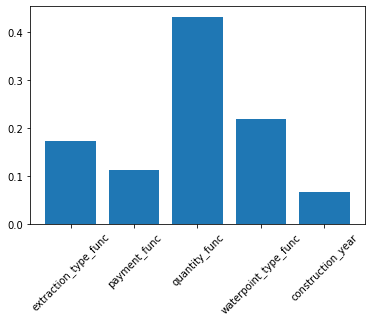

In [180]:
feature_label = X_func.columns
feature_importance =m_rf.feature_importances_
plt.bar(feature_label, feature_importance)
plt.xticks(rotation=45)
plt.show()


## Feature Importance DataFrame ##

In [131]:
features = zip(feature_label, feature_importance)
ft = list(features)
ft
feat = pd.DataFrame(ft, columns =  ['feature_label', 'feature_importance'], index = feature_label )

In [132]:
imp_df =feat[['feature_importance']]

In [133]:
imp_df

,feature_importance
extraction_type_func,0.113762
payment_func,0.125450
quantity_func,0.446355
waterpoint_type_func,0.259146
construction_year,0.055286


## Creating a DataFrame that has Status_gr and Prediction for each Index ##
### (Requested output for the challenge) ###

In [134]:
predictions = zip(num_dumm_cat['status_group'], y_pred_rf)
final_df = pd.DataFrame(predictions, columns =  ['status_group', 'prediction'] ,index = num_dumm_cat.index)
final_df['prediction'].replace({1: 'functional', 0:'non functional'}, inplace = True)

In [135]:
final_df.head(20)

,status_group,prediction
454,functional,functional
510,functional,functional
14146,non functional,non functional
47410,non functional,functional
1288,non functional,non functional
13095,functional,functional
558,functional,functional
35626,functional,functional
8696,non functional,functional
48650,functional,functional


## Save DataFrame as .csv ##

In [136]:
final_df.to_csv('Data_and_Predictions.csv', index_label = 'id')
